## Feature selection

Random forests is one the most popular machine learning algorithms. It is so successful because it provide good predictive performance, low overfitting and easy interpretability. This interpretability is given by the fact that it is straightforward to derive the importance of each variable on the tree decision. In other words, it is easy to compute how much each variable is contributing to the decision.

Random forests consist typically of 4-12 hundred decision trees, each of them built over a random extraction of the observations from the dataset and a random extraction of the features. Not every tree sees all the features or all the observations, and this guarantees that the trees are de-correlated and therefore less prone to over-fitting. Each tree is also a sequence of yes-no questions based on a single or a combination of features. At each node (that is, at each question), the three divides the dataset in 2 buckets, each of them hosting observations that are more similar among themselves and different from the ones in the other bucket. Therefore, the importance of each feature is derived by how "pure" each of the buckets is.

For classification, the measure of impurity is either Gini or the entropy. For regression the measure of impurity is the variance. When training a tree, it is possible to compute how much each feature decreases the impurity. The more a feature decreases the impurity, the more important the feature is. In random forests, the impurity decrease elicited by each feature is averaged across trees to determine the final importance of the variable.

In general, features that are selected at the top of the trees are more important than features that are selected at the end nodes of the trees, as generally the top splits lead to bigger information gains.

Note

Random Forests and decision trees in general give preference to features with high cardinality
Correlated features will be given equal or similar importance, but overall reduced importance compared to the same tree built without correlated counterparts.
I will demonstrate how to select features based on tree importance using a regression and classification datase

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv
import os

from sklearn.pipeline import Pipeline
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, SelectByShuffling
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import BayesianRidge

import xgboost as xgb
from xgboost import XGBClassifier
from ngboost import NGBClassifier
from ngboost.distns import k_categorical

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, balanced_accuracy_score

In [21]:
# Import dataset
load_dotenv()
dataset_path=os.getenv("DATASET_PATH")
dataset = pd.read_csv(dataset_path)
dataset.head()

,RID,Gender,Ageatscreening,Diagnosis,MMSE0m,HipsASMbaseline,HipsContrastbaseline,HipsCorelationbaseline,HipsVariancebaseline,HipsSumAveragebaseline,...,ERCsContrastbaseline,ERCsCorelationbaseline,ERCsVariancebaseline,ERCsSumAveragebaseline,ERCsSumVariancebaseline,ERCsEntropybaseline,ERCsClusterShadebaseline,ERCs_thicknessbaseline,ERCsVolumebaseline,HipposcampusVolumebaseline
0,3,0,81.3479,3,20.0,NaN,158.27,0.63,218.30,28.37,...,253.10,0.40,208.65,23.39,581.50,NaN,-2568.19,2.31,1176.0,3047.0
1,4,0,67.6904,1,27.0,0.06,147.64,0.55,173.64,44.72,...,220.88,0.48,215.70,33.74,641.90,3.33,4113.01,2.76,1942.0,3449.0
2,5,0,73.8027,0,29.0,0.10,199.66,0.55,222.27,41.18,...,220.37,0.54,232.18,29.18,708.36,2.87,-1388.41,3.18,2044.0,3441.0
3,8,1,84.5945,0,28.0,0.08,184.21,0.53,201.55,43.04,...,198.42,0.54,220.48,26.68,683.50,2.77,-2506.55,2.68,1959.0,2875.0
4,10,1,73.9726,3,24.0,0.11,233.02,0.48,229.88,39.46,...,196.55,0.53,210.63,26.60,645.95,2.72,-1164.02,2.64,1397.0,2700.0


In [22]:
group_one = dataset[dataset["Diagnosis"] == 0]
group_two = dataset[dataset["Diagnosis"] == 3]

combined_group_two = pd.concat([group_one, group_two], ignore_index = True)
combined_group_two["Diagnosis"].unique()

array([0, 3])

In [23]:
combined_group_two

,RID,Gender,Ageatscreening,Diagnosis,MMSE0m,HipsASMbaseline,HipsContrastbaseline,HipsCorelationbaseline,HipsVariancebaseline,HipsSumAveragebaseline,...,ERCsContrastbaseline,ERCsCorelationbaseline,ERCsVariancebaseline,ERCsSumAveragebaseline,ERCsSumVariancebaseline,ERCsEntropybaseline,ERCsClusterShadebaseline,ERCs_thicknessbaseline,ERCsVolumebaseline,HipposcampusVolumebaseline
0,5,0,73.8027,0,29.0,0.10,199.66,0.55,222.27,41.18,...,220.37,0.54,232.18,29.18,708.36,2.87,-1388.41,3.18,2044.0,3441.0
1,8,1,84.5945,0,28.0,0.08,184.21,0.53,201.55,43.04,...,198.42,0.54,220.48,26.68,683.50,2.77,-2506.55,2.68,1959.0,2875.0
2,14,1,78.6137,0,29.0,0.12,188.33,0.49,183.76,39.63,...,241.64,0.44,226.48,35.11,664.29,3.10,8478.33,3.01,1809.0,3292.0
3,15,0,80.9068,0,29.0,0.10,161.28,0.54,174.53,35.94,...,221.76,0.45,NaN,30.57,NaN,3.12,4287.78,2.90,2188.0,3603.0
4,16,0,65.5205,0,28.0,0.12,166.97,0.58,202.96,38.42,...,228.53,0.50,228.72,28.98,686.36,2.90,-1381.99,2.73,1829.0,3695.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,1201,1,75.6411,3,26.0,0.18,173.84,0.59,215.04,33.84,...,281.15,0.37,222.73,27.94,609.75,2.84,-1924.49,1.94,1112.0,2705.0
320,1221,0,71.2712,3,21.0,0.22,174.02,0.58,211.07,30.56,...,224.78,0.47,205.49,27.36,597.20,2.77,1146.39,2.44,1526.0,2913.0
321,1248,1,79.8548,3,23.0,0.19,199.31,0.56,229.63,33.13,...,220.41,0.48,214.97,27.16,639.47,2.79,-919.84,1.99,1215.0,2273.0
322,1253,1,62.7452,3,24.0,0.05,142.05,0.50,147.12,46.21,...,217.38,0.51,220.55,32.54,664.84,3.09,5289.89,3.27,2321.0,3739.0


In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    combined_group_two.drop("Diagnosis", axis=1),  
    combined_group_two["Diagnosis"],  
    test_size=0.3,  
    random_state=42,  
)

In [25]:
imputer_bayes = IterativeImputer(
    estimator=BayesianRidge(),
    random_state=42,
)

imputer_bayes.fit(X_train)
X_train_bayes = imputer_bayes.transform(X_train)
X_test_bayes = imputer_bayes.transform(X_test)

In [26]:
X_train_bayes_t = pd.DataFrame(
    X_train_bayes, 
    columns=X_train.columns, 
    index=X_train.index  # Critical fix
)
X_test_bayes_t = pd.DataFrame(
    X_test_bayes, 
    columns=X_test.columns, 
    index=X_test.index  # Critical fix
)

In [27]:
pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=1, variables=None, missing_values='raise')),
    ('quasi-constant', DropConstantFeatures(tol=0.998, variables=None, missing_values='raise')),
    ('duplicated', DropDuplicateFeatures()),
])

pipe.fit(X_train_bayes_t)

Pipeline(steps=[('constant', DropConstantFeatures()),
                ('quasi-constant', DropConstantFeatures(tol=0.998)),
                ('duplicated', DropDuplicateFeatures())])

In [28]:
constant_step = pipe.named_steps['constant']
quasi_constant_step = pipe.named_steps['quasi-constant']
duplicated_step = pipe.named_steps['duplicated']

print("Constant features removed:", constant_step.features_to_drop_)
print("Quasi-constant features removed:", quasi_constant_step.features_to_drop_)
print("Duplicate features removed:", duplicated_step.features_to_drop_)

Constant features removed: []
Quasi-constant features removed: []
Duplicate features removed: set()


In [29]:
X_train_t = pipe.transform(X_train_bayes_t)
X_test_t = pipe.transform(X_test_bayes_t)

X_train_t.shape, X_test_t.shape

((226, 23), (98, 23))

In [30]:
# we fit Random Forests and select features in 2 lines of code

# first I specify the Random Forest instance and its parameters

# Then I use the selectFromModel class from sklearn
# to automatically select the features

# SelectFrom model will select those features which importance
# is greater than the mean importance of all the features
# by default, but you can alter this threshold if you want to

sel_ = SelectFromModel(RandomForestClassifier())

sel_.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier())

In [31]:
# this command let's me visualise those features that were selected.

# sklearn will select those features which importance values
# are greater than the mean of all the coefficients.

sel_.get_support()

array([False, False, False,  True, False, False, False, False, False,
       False, False, False, False,  True,  True, False, False, False,
       False, False,  True,  True,  True])

In [32]:
# let's make a list and count the selected features

selected_feat = X_train.columns[(sel_.get_support())]
selected_feat

Index(['MMSE0m', 'ERCsContrastbaseline', 'ERCsCorelationbaseline',
       'ERCs_thicknessbaseline', 'ERCsVolumebaseline',
       'HipposcampusVolumebaseline'],
      dtype='object')

In [33]:
sel_.get_feature_names_out

<bound method SelectorMixin.get_feature_names_out of SelectFromModel(estimator=RandomForestClassifier())>

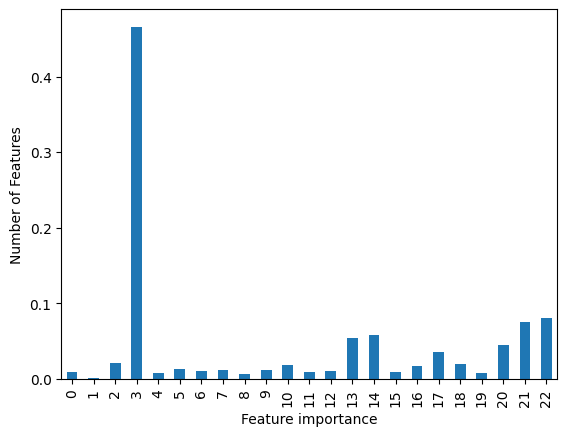

In [34]:
# and now let's plot the distribution of importances

pd.Series(sel_.estimator_.feature_importances_.ravel()).plot(kind="bar")
plt.xlabel('Feature importance')
plt.ylabel('Number of Features')
plt.show()

In [35]:
X_train_t = pd.DataFrame(sel_.transform(X_train_bayes_t))
X_test_t = pd.DataFrame(sel_.transform(X_test_bayes_t))

# add the columns name
X_train_t.columns = X_train.columns[(sel_.get_support())]
X_test_t.columns = X_train.columns[(sel_.get_support())]

X_train_t.shape, X_test_t.shape

((226, 6), (98, 6))

## Classification Test

In [36]:
from ngboost.distns import Bernoulli
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

def run_model(classifier_name, X_train, y_train):
        
        columns = len(X_train.columns)

        # Initialize the model based on classifier_name
        if classifier_name == "Random Forest":
                model = RandomForestClassifier(n_estimators=100, 
                                        max_depth=5, 
                                        random_state=42, 
                                        class_weight="balanced")
                
        elif classifier_name == "XGBoost":
        # XGBClassifier sometimes issues warnings about label encoding. 
        # We disable the use_label_encoder and set an evaluation metric.
                model = XGBClassifier(n_estimators=100, 
                                max_depth=5, 
                                random_state=42,
                                eval_metric="logloss",
                                use_label_encoder=False,
                                objective="binary:logistic",
                                verbosity=0)
        
        elif classifier_name == "NGBoost":
                model = NGBClassifier(Dist=k_categorical(2),
                                      n_estimators=100,
                                      verbose=False) 
                
        elif classifier_name == "Logistic Regression":
                model = LogisticRegression(
                class_weight="balanced",
                solver="lbfgs",
                max_iter=500,
                random_state=42
                )
                
                # Scale features
                scaler = StandardScaler()
                X_train = scaler.fit_transform(X_train)

        else:
                raise ValueError("Unknown classifier")
                
        kf = StratifiedKFold(n_splits=10,
                             shuffle=True,
                             random_state=42,
        )
        
        cross_val_results = cross_validate(model,
                                           X_train,
                                           y_train,
                                           cv=kf,
                                           scoring="balanced_accuracy",
                                           return_train_score=True,
        )
               
        # Calculate the metrics for training and testing
        mean_train = [round(np.mean(cross_val_results["train_score"]), 3)]
        std_train = [round(np.std(cross_val_results["train_score"]), 3)]
        mean_test = [round(np.mean(cross_val_results["test_score"]), 3)]
        std_test = [round(np.std(cross_val_results["test_score"]), 3)]
        time = round(np.mean(cross_val_results["fit_time"]), 3)
                
        cv_metrics_df = pd.DataFrame({
                "Feature Selection": "Boruta",
                "Classifier": classifier_name,
                "Fit Time": time,
                "Total Features": columns,
                "Metric": "balanced_accuracy",
                "Mean Train": mean_train,
                "Std Train": std_train,
                "Mean Test": mean_test,
                "Std Test": std_test,
        })
        
        fit_model = model.fit(X_train, y_train)
        
        return fit_model, cv_metrics_df


In [37]:
from sklearn.preprocessing import LabelEncoder

# 1) Fit a label encoder on the training labels:
le_train = LabelEncoder().fit(y_train)
le_test = LabelEncoder().fit(y_test)

# 2) Transform y_train (and later y_test) to {0,1} internally:
y_train_enc = le_train.transform(y_train)
y_test_enc = le_test.transform(y_test)

In [38]:
trained_rf_n, metrics_rf_n = run_model("Random Forest", X_train_bayes_t, y_train_enc)
trained_rf_t, metrics_rf_t = run_model("Random Forest", X_train_t, y_train_enc)

trained_xgb_n, metrics_xgb_n = run_model("XGBoost", X_train_bayes_t, y_train_enc)
trained_xgb_t, metrics_xgb_t = run_model("XGBoost", X_train_t, y_train_enc)

trained_ngb_n, metrics_ngb_n = run_model("NGBoost", X_train_bayes_t, y_train_enc)
trained_ngb_t, metrics_ngb_t = run_model("NGBoost", X_train_t, y_train_enc)

trained_lg_n, metrics_lg_n = run_model("Logistic Regression", X_train_bayes_t, y_train_enc)
trained_lg_t, metrics_lg_t = run_model("Logistic Regression", X_train_t, y_train_enc)

In [39]:
validation_df = pd.concat([metrics_rf_n, metrics_rf_t, metrics_xgb_n, metrics_xgb_t, metrics_ngb_n, metrics_ngb_t, metrics_lg_n, metrics_lg_t])
validation_df_report = validation_df.set_index(["Feature Selection", "Classifier", "Fit Time", "Total Features", "Metric"])
validation_df_report

Mean Train  \
Feature Selection Classifier          Fit Time Total Features Metric                          
Boruta            Random Forest       0.463    23             balanced_accuracy       1.000   
                                      0.306    6              balanced_accuracy       1.000   
                  XGBoost             0.112    23             balanced_accuracy       1.000   
                                      0.067    6              balanced_accuracy       1.000   
                  NGBoost             0.634    23             balanced_accuracy       1.000   
                                      0.489    6              balanced_accuracy       0.998   
                  Logistic Regression 0.008    23             balanced_accuracy       0.987   
                                      0.007    6              balanced_accuracy       0.975   

                                                                                 Std Train  \
Feature Selection Classifier          Fit Time Total Features Metric                         
Boruta            Random Forest       0.463    23             balanced_accuracy      0.000   
                                      0.306    6              balanced_accuracy      0.001   
                  XGBoost             0.112    23             balanced_accuracy      0.000   
                                      0.067    6              balanced_accuracy      0.000   
                  NGBoost             0.634    23             balanced_accuracy      0.001   
                                      0.489    6              balanced_accuracy      0.002   
                  Logistic Regression 0.008    23             balanced_accuracy      0.002   
                                      0.007    6              balanced_accuracy      0.004   

                                                                                 Mean Test  \
Feature Selection Classifier          Fit Time Total Features Metric                         
Boruta            Random Forest       0.463    23             balanced_accuracy      0.973   
                                      0.306    6              balanced_accuracy      0.965   
                  XGBoost             0.112    23             balanced_accuracy      0.967   
                                      0.067    6              balanced_accuracy      0.969   
                  NGBoost             0.634    23             balanced_accuracy      0.952   
                                      0.489    6              balanced_accuracy      0.962   
                  Logistic Regression 0.008    23             balanced_accuracy      0.974   
                                      0.007    6              balanced_accuracy      0.970   

                                                                                 Std Test  
Feature Selection Classifier          Fit Time Total Features Metric                       
Boruta            Random Forest       0.463    23             balanced_accuracy     0.031  
                                      0.306    6              balanced_accuracy     0.031  
                  XGBoost             0.112    23             balanced_accuracy     0.035  
                                      0.067    6              balanced_accuracy     0.039  
                  NGBoost             0.634    23             balanced_accuracy     0.049  
                                      0.489    6              balanced_accuracy     0.033  
                  Logistic Regression 0.008    23             balanced_accuracy     0.034  
                                      0.007    6              balanced_accuracy     0.033

In [42]:
import time

def eval_model(classifier_name, model, X_train, X_test, y_train, y_test):
        
        start_time = time.time()
        columns = len(X_train.columns)
        
        if classifier_name == "Logistic Regression":  
                # Scale features
                scaler = StandardScaler()
                X_train = scaler.fit_transform(X_train)
                X_test = scaler.fit_transform(X_test)
                
        # Get predicted probabilities for ROC AUC
        pred_train_proba = model.predict_proba(X_train)
        pred_test_proba = model.predict_proba(X_test)
        
        # Get predicted accuracy values
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)
        
        # Calculate metrics
        metrics_train = {
                "accuracy": round(accuracy_score(y_train, pred_train), 3),
                "balanced_accuracy": round(balanced_accuracy_score(y_train, pred_train), 3),
                "precision": round(precision_score(y_train, pred_train, average="binary"), 3),
                "recall": round(recall_score(y_train, pred_train, average="binary"), 3),
                "f1": round(f1_score(y_train, pred_train, average="binary"), 3),
                "roc_auc_ovr": round(roc_auc_score(y_train, pred_train_proba[:, 1]),3,),
        }
        
        metrics_test = {
                "accuracy": round(accuracy_score(y_test, pred_test), 3),
                "balanced_accuracy": round(balanced_accuracy_score(y_test, pred_test), 3),
                "precision": round(precision_score(y_test, pred_test, average="binary"), 3),
                "recall": round(recall_score(y_test, pred_test, average="binary"), 3),
                "f1": round(f1_score(y_test, pred_test, average="binary"), 3),
                "roc_auc_ovr": round(roc_auc_score(y_test, pred_test_proba[:, 1]),3,),
        }
                
        elapsed_time = time.time() - start_time
    
        # Create the DataFrame without additional rounding
        pred_metrics_df = pd.DataFrame({
                "Feature Selection": "RFI",
                "Classifier": classifier_name,
                "Classification Time": round(elapsed_time, 3),
                "Total Features": columns,
                "Metric": metrics_train.keys(),
                "Train data": metrics_train.values(),
                "Test data": metrics_test.values(),
    })
        
        return pred_metrics_df

In [43]:
results = "all"
prediction_df_report = None

if results == "all":
    pred_rf_n = eval_model("Random Forest", trained_rf_n, X_train_bayes_t, X_test_bayes_t, y_train_enc, y_test_enc)
    pred_rf_t = eval_model("Random Forest", trained_rf_t, X_train_t, X_test_t, y_train_enc, y_test_enc)

    pred_xgb_n = eval_model("XGBoost", trained_xgb_n, X_train_bayes_t, X_test_bayes_t, y_train_enc, y_test_enc)
    pred_xgb_t = eval_model("XGBoost", trained_xgb_t, X_train_t, X_test_t, y_train_enc, y_test_enc)

    pred_ngb_n = eval_model("NGBoost", trained_ngb_n, X_train_bayes_t, X_test_bayes_t, y_train_enc, y_test_enc)
    pred_ngb_t = eval_model("NGBoost", trained_ngb_t, X_train_t, X_test_t, y_train_enc, y_test_enc)
    
    pred_lg_n = eval_model("Logistic Regression", trained_lg_n, X_train_bayes_t, X_test_bayes_t, y_train_enc, y_test_enc)
    pred_lg_t = eval_model("Logistic Regression", trained_lg_t, X_train_t, X_test_t, y_train_enc, y_test_enc)
    
    prediction_df = pd.concat([pred_rf_n, pred_rf_t, pred_xgb_n, pred_xgb_t, pred_ngb_n, pred_ngb_t, pred_lg_n, pred_lg_t])
    prediction_df_report = prediction_df.set_index(["Feature Selection", "Classifier", "Classification Time", "Total Features", "Metric"])
        
elif results == "filtered":
    pred_rf_t = eval_model("Random Forest", trained_rf_t, X_train_t, X_test_t, y_train_enc, y_test_enc)
    pred_xgb_t = eval_model("XGBoost", trained_xgb_t, X_train_t, X_test_t, y_train_enc, y_test_enc)
    pred_ngb_t = eval_model("NGBoost", trained_ngb_t, X_train_t, X_test_t, y_train_enc, y_test_enc)
    pred_lg_t = eval_model("Logistic Regression", trained_lg_t, X_train_t, X_test_t, y_train_enc, y_test_enc)

    prediction_df = pd.concat([pred_rf_t, pred_xgb_t, pred_ngb_t, pred_lg_t])
    prediction_df_report = prediction_df.set_index(["Feature Selection", "Classifier", "Classification Time", "Total Features", "Metric"])

prediction_df_report

Train data  \
Feature Selection Classifier          Classification Time Total Features Metric                          
RFI               Random Forest       0.621               23             accuracy                1.000   
                                                                         balanced_accuracy       1.000   
                                                                         precision               1.000   
                                                                         recall                  1.000   
                                                                         f1                      1.000   
                                                                         roc_auc_ovr             1.000   
                                      0.207               6              accuracy                1.000   
                                                                         balanced_accuracy       1.000   
                                                                         precision               1.000   
                                                                         recall                  1.000   
                                                                         f1                      1.000   
                                                                         roc_auc_ovr             1.000   
                  XGBoost             0.151               23             accuracy                1.000   
                                                                         balanced_accuracy       1.000   
                                                                         precision               1.000   
                                                                         recall                  1.000   
                                                                         f1                      1.000   
                                                                         roc_auc_ovr             1.000   
                                      0.119               6              accuracy                1.000   
                                                                         balanced_accuracy       1.000   
                                                                         precision               1.000   
                                                                         recall                  1.000   
                                                                         f1                      1.000   
                                                                         roc_auc_ovr             1.000   
                  NGBoost             0.341               23             accuracy                1.000   
                                                                         balanced_accuracy       1.000   
                                                                         precision               1.000   
                                                                         recall                  1.000   
                                                                         f1                      1.000   
                                                                         roc_auc_ovr             1.000   
                                      0.466               6              accuracy                1.000   
                                                                         balanced_accuracy       1.000   
                                                                         precision               1.000   
                                                                         recall                  1.000   
                                                                         f1                      1.000   
                                                                         roc_auc_ovr             1.000   
                  Logistic Regression 0.075               23    